In [6]:
!pip install tensorflow noisereduce

In [7]:
# import all necessary libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import IPython.display as ipd
import noisereduce as nr
import pickle

In [8]:
# Imports for the feature calculting functions
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

# ML Models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# DL Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# mount drive in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# path info
parent_audio_dir = '/content/drive/MyDrive/heart_sound'
project_dir = '/content/drive/MyDrive/capstone_2'
train_dir = parent_audio_dir + '/train'
normal_sound_dir = train_dir + '/healthy'
abnormal_sound_dir = train_dir + '/unhealthy'
other_sounds = parent_audio_dir + '/other_sounds/ESC-50-master/audio'

In [12]:
# define the feature calculting functions
SAMPLE_RATE = 22050

# ---------- TIME DOMAIN FEATURES ----------
def peak_amplitude(y):
    """Peak amplitude in time domain"""
    return np.max(np.abs(y))

def total_power_time(y):
    """Total signal power in time domain"""
    return np.sum(y**2) / len(y)

def zero_crossing_rate(y):
    """Zero Crossing Rate"""
    return np.mean(librosa.feature.zero_crossing_rate(y))

# ---------- FREQUENCY DOMAIN FEATURES ----------
def compute_fft(y, sr=SAMPLE_RATE):
    """Compute FFT magnitude and frequency bins"""
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, 1/sr)[:N//2]
    magnitude = 2.0/N * np.abs(yf[0:N//2])
    return xf, magnitude

def peak_frequency(y, sr=SAMPLE_RATE):
    """Peak frequency from FFT"""
    xf, mag = compute_fft(y, sr)
    return xf[np.argmax(mag)]

def peak_amplitude_freq(y, sr=SAMPLE_RATE):
    """Peak amplitude in frequency domain"""
    xf, mag = compute_fft(y, sr)
    return np.max(mag)

def total_power_freq(y, sr=SAMPLE_RATE):
    """Total power in frequency domain"""
    xf, mag = compute_fft(y, sr)
    return np.sum(mag**2) / len(mag)

def bandwidth(y, sr=SAMPLE_RATE):
    """Spectral bandwidth"""
    return np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

def q_factor(y, sr=SAMPLE_RATE):
    """Q-factor = peak freq / bandwidth"""
    pf = peak_frequency(y, sr)
    bw = bandwidth(y, sr)
    return pf / bw if bw != 0 else 0

# ---------- CEPSTRUM FEATURES ----------
def cepstrum_peak_amplitude(y):
    """Cepstrum peak amplitude"""
    spectrum = np.abs(fft(y))
    log_spectrum = np.log(spectrum + 1e-10)
    cepstrum = np.abs(np.fft.ifft(log_spectrum))
    return np.max(cepstrum)

# ---------- STATISTICAL FEATURES ----------
def mean_stat(y):
    """Mean amplitude"""
    return np.mean(y)

def std_stat(y):
    """Standard deviation of amplitude"""
    return np.std(y)

def min_max_stat(y):
    """Min and max amplitude"""
    return np.min(y), np.max(y)

# ---------- MFCC FEATURES ----------
def mfcc_features(y, sr=SAMPLE_RATE, n_mfcc=13):
    """Compute mean of MFCC coefficients"""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return [np.mean(mfccs[i]) for i in range(n_mfcc)]

In [13]:
def extract_all_features(y, sr=SAMPLE_RATE):
    features = {}

    # Time domain
    features["peak_amplitude"] = peak_amplitude(y)
    features["total_power_time"] = total_power_time(y)
    features["zcr"] = zero_crossing_rate(y)

    # Frequency domain
    features["peak_frequency"] = peak_frequency(y, sr)
    features["peak_amplitude_freq"] = peak_amplitude_freq(y, sr)
    features["total_power_freq"] = total_power_freq(y, sr)
    features["bandwidth"] = bandwidth(y, sr)
    features["q_factor"] = q_factor(y, sr)

    # Cepstrum
    features["cepstrum_peak_amplitude"] = cepstrum_peak_amplitude(y)

    # Statistical
    features["mean"] = mean_stat(y)
    features["std"] = std_stat(y)
    features["min"], features["max"] = min_max_stat(y)

    # MFCCs (mfcc1 … mfcc13)
    mfccs = mfcc_features(y, sr, n_mfcc=13)
    for i, val in enumerate(mfccs, start=1):
        features[f"mfcc{i}"] = val

    return features

In [14]:
# read all the files for model training
SAMPLE_RATE = 22050
DURATION = 5.0
SAMPLES_PER_FILE = int(SAMPLE_RATE * DURATION)
AUDIO_EXTS = (".wav")

In [15]:
def load_audio(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """Load audio file and pad/truncate to fixed duration."""
    y, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    if len(y) < SAMPLES_PER_FILE:
        y = np.pad(y, (0, SAMPLES_PER_FILE - len(y)), mode="constant")
    return y[:SAMPLES_PER_FILE]

In [16]:
X = []
y_labels = []

# Normal sounds
for file in os.listdir(normal_sound_dir):
    if file.endswith(AUDIO_EXTS):
        y_audio = load_audio(os.path.join(normal_sound_dir, file))
        feats = extract_all_features(y_audio)
        X.append(feats)
        y_labels.append(0)

# Abnormal sounds
for file in os.listdir(abnormal_sound_dir):
    if file.endswith(AUDIO_EXTS):
        y_audio = load_audio(os.path.join(abnormal_sound_dir, file))
        feats = extract_all_features(y_audio)
        X.append(feats)
        y_labels.append(0)

# Other sounds
for file in os.listdir(other_sounds):
    if file.endswith(AUDIO_EXTS):
        y_audio = load_audio(os.path.join(other_sounds, file))
        feats = extract_all_features(y_audio)
        X.append(feats)
        y_labels.append(1)


# Convert to DataFrame
df = pd.DataFrame(X)
df["label"] = y_labels

print("Dataset shape:", df.shape)

Dataset shape: (5270, 27)


In [17]:
df.to_csv(f'{project_dir}/data/heart_sound_plus_other_sounds_dataset.csv', index=False)

In [18]:
X = []
y_labels = []

# Normal sounds
for file in os.listdir(normal_sound_dir):
    if file.endswith(AUDIO_EXTS):
        y_audio = load_audio(os.path.join(normal_sound_dir, file))
        y_audio = nr.reduce_noise(y=y_audio, sr=SAMPLE_RATE)
        feats = extract_all_features(y_audio)
        X.append(feats)
        y_labels.append(0)

# Abnormal sounds
for file in os.listdir(abnormal_sound_dir):
    if file.endswith(AUDIO_EXTS):
        y_audio = load_audio(os.path.join(abnormal_sound_dir, file))
        y_audio = nr.reduce_noise(y=y_audio, sr=SAMPLE_RATE)
        feats = extract_all_features(y_audio)
        X.append(feats)
        y_labels.append(0)

# Other sounds
for file in os.listdir(other_sounds):
    if file.endswith(AUDIO_EXTS):
        y_audio = load_audio(os.path.join(other_sounds, file))
        y_audio = nr.reduce_noise(y=y_audio, sr=SAMPLE_RATE)
        feats = extract_all_features(y_audio)
        X.append(feats)
        y_labels.append(1)


# Convert to DataFrame
df_nr = pd.DataFrame(X)
df_nr["label"] = y_labels

print("Dataset shape:", df_nr.shape)

Dataset shape: (5270, 27)


In [19]:
df.to_csv(f'{project_dir}/data/heart_sound_plus_other_sounds_dataset_noise_removed.csv', index=False)

In [20]:
df = pd.read_csv(f'{project_dir}/data/heart_sound_plus_other_sounds_dataset.csv')
df_nr = pd.read_csv(f'{project_dir}/data/heart_sound_plus_other_sounds_dataset_noise_removed.csv')

In [21]:
df.head()

,peak_amplitude,total_power_time,zcr,peak_frequency,peak_amplitude_freq,total_power_freq,bandwidth,q_factor,cepstrum_peak_amplitude,mean,...,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,label
0,0.261564,0.001560,0.007288,27.2,0.008168,5.660401e-08,175.175269,0.155273,5.810622,0.000315,...,11.460621,-0.589286,7.237066,22.394278,31.592215,28.520761,16.240238,3.445810,-2.234304,0
1,0.604016,0.015591,0.045098,0.0,0.070882,6.112447e-07,288.865694,0.000000,3.606365,-0.035441,...,-43.064420,-63.513890,-33.523594,11.853672,38.343210,32.558960,5.562667,-19.435860,-25.166277,0
2,0.899052,0.009909,0.014719,26.6,0.023344,3.596986e-07,232.150866,0.114581,3.902777,0.002293,...,7.408609,-1.748757,5.322455,18.688206,27.439050,26.058517,16.571121,5.783592,0.104923,0
3,1.270802,0.032566,0.003646,17.0,0.043401,1.190717e-06,165.638761,0.102633,2.071089,0.015918,...,25.059230,14.906037,13.073594,15.551526,17.416256,15.876282,11.290831,6.255780,3.421517,0
4,0.368150,0.001874,0.010166,29.2,0.007088,6.801711e-08,209.180257,0.139593,3.576738,0.000596,...,9.268703,-2.914247,5.394984,21.301674,31.109133,28.223986,15.627984,2.097624,-4.573679,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5270 entries, 0 to 5269
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   peak_amplitude           5270 non-null   float64
 1   total_power_time         5270 non-null   float64
 2   zcr                      5270 non-null   float64
 3   peak_frequency           5270 non-null   float64
 4   peak_amplitude_freq      5270 non-null   float64
 5   total_power_freq         5270 non-null   float64
 6   bandwidth                5270 non-null   float64
 7   q_factor                 5270 non-null   float64
 8   cepstrum_peak_amplitude  5270 non-null   float64
 9   mean                     5270 non-null   float64
 10  std                      5270 non-null   float64
 11  min                      5270 non-null   float64
 12  max                      5270 non-null   float64
 13  mfcc1                    5270 non-null   float64
 14  mfcc2                   

In [23]:
df_nr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5270 entries, 0 to 5269
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   peak_amplitude           5270 non-null   float64
 1   total_power_time         5270 non-null   float64
 2   zcr                      5270 non-null   float64
 3   peak_frequency           5270 non-null   float64
 4   peak_amplitude_freq      5270 non-null   float64
 5   total_power_freq         5270 non-null   float64
 6   bandwidth                5270 non-null   float64
 7   q_factor                 5270 non-null   float64
 8   cepstrum_peak_amplitude  5270 non-null   float64
 9   mean                     5270 non-null   float64
 10  std                      5270 non-null   float64
 11  min                      5270 non-null   float64
 12  max                      5270 non-null   float64
 13  mfcc1                    5270 non-null   float64
 14  mfcc2                   

In [24]:
df.describe()

,peak_amplitude,total_power_time,zcr,peak_frequency,peak_amplitude_freq,total_power_freq,bandwidth,q_factor,cepstrum_peak_amplitude,mean,...,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,label
count,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5.270000e+03,5270.000000,5270.000000,5270.000000,5270.000000,...,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000
mean,0.665663,0.018326,0.051424,324.322998,0.053755,7.636233e-07,873.768012,0.275559,3.064309,-0.016614,...,8.193615,4.167851,4.252205,12.944466,15.403065,15.578838,8.344282,3.753747,-0.314762,0.379507
std,0.323134,0.033657,0.085102,953.060253,0.099120,1.507252e-06,1005.349558,0.781745,1.775684,0.049450,...,17.541630,15.190194,12.079455,10.720754,15.367773,12.459780,9.925739,6.349126,6.685635,0.485310
min,0.013034,0.000004,0.000036,0.000000,0.000092,1.349551e-10,49.493979,0.000000,0.236301,-0.472575,...,-88.316160,-65.684650,-83.483284,-48.350883,-43.266144,-33.741035,-40.961468,-33.024750,-43.411324,0.000000
25%,0.373312,0.001689,0.004329,0.000000,0.007419,6.267926e-08,163.325592,0.000000,1.448056,-0.006559,...,-2.464742,-5.535599,-3.157556,5.943964,1.538677,4.630238,0.842746,0.253236,-4.257629,0.000000
50%,0.745241,0.006812,0.010163,32.000000,0.017522,2.541959e-07,226.269877,0.112143,2.951446,-0.000043,...,7.573746,3.657633,4.342165,15.828124,20.085577,19.402129,12.928259,3.733988,-0.671050,0.000000
75%,0.954604,0.018553,0.071397,120.000000,0.045102,7.218016e-07,1721.936680,0.241110,4.402388,0.000050,...,19.332708,14.060192,12.240711,20.798365,28.661294,26.202548,15.945578,7.509625,3.333598,1.000000
max,1.656770,0.441895,0.902816,10419.800000,0.945151,1.695162e-05,4212.481439,17.409805,11.130290,0.142859,...,109.280920,69.392170,45.512478,60.965885,49.112133,47.168953,45.266920,42.492367,41.731537,1.000000


In [25]:
df_nr.describe()

,peak_amplitude,total_power_time,zcr,peak_frequency,peak_amplitude_freq,total_power_freq,bandwidth,q_factor,cepstrum_peak_amplitude,mean,...,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,label
count,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5.270000e+03,5270.000000,5270.000000,5270.000000,5270.000000,...,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000
mean,0.665663,0.018326,0.051424,324.322998,0.053755,7.636233e-07,873.768012,0.275559,3.064309,-0.016614,...,8.193615,4.167851,4.252205,12.944466,15.403065,15.578838,8.344282,3.753747,-0.314762,0.379507
std,0.323134,0.033657,0.085102,953.060253,0.099120,1.507252e-06,1005.349558,0.781745,1.775684,0.049450,...,17.541630,15.190194,12.079455,10.720754,15.367773,12.459780,9.925739,6.349126,6.685635,0.485310
min,0.013034,0.000004,0.000036,0.000000,0.000092,1.349551e-10,49.493979,0.000000,0.236301,-0.472575,...,-88.316160,-65.684650,-83.483284,-48.350883,-43.266144,-33.741035,-40.961468,-33.024750,-43.411324,0.000000
25%,0.373312,0.001689,0.004329,0.000000,0.007419,6.267926e-08,163.325592,0.000000,1.448056,-0.006559,...,-2.464742,-5.535599,-3.157556,5.943964,1.538677,4.630238,0.842746,0.253236,-4.257629,0.000000
50%,0.745241,0.006812,0.010163,32.000000,0.017522,2.541959e-07,226.269877,0.112143,2.951446,-0.000043,...,7.573746,3.657633,4.342165,15.828124,20.085577,19.402129,12.928259,3.733988,-0.671050,0.000000
75%,0.954604,0.018553,0.071397,120.000000,0.045102,7.218016e-07,1721.936680,0.241110,4.402388,0.000050,...,19.332708,14.060192,12.240711,20.798365,28.661294,26.202548,15.945578,7.509625,3.333598,1.000000
max,1.656770,0.441895,0.902816,10419.800000,0.945151,1.695162e-05,4212.481439,17.409805,11.130290,0.142859,...,109.280920,69.392170,45.512478,60.965885,49.112133,47.168953,45.266920,42.492367,41.731537,1.000000


In [26]:
df.label.value_counts()

,count
label,
0,3270
1,2000


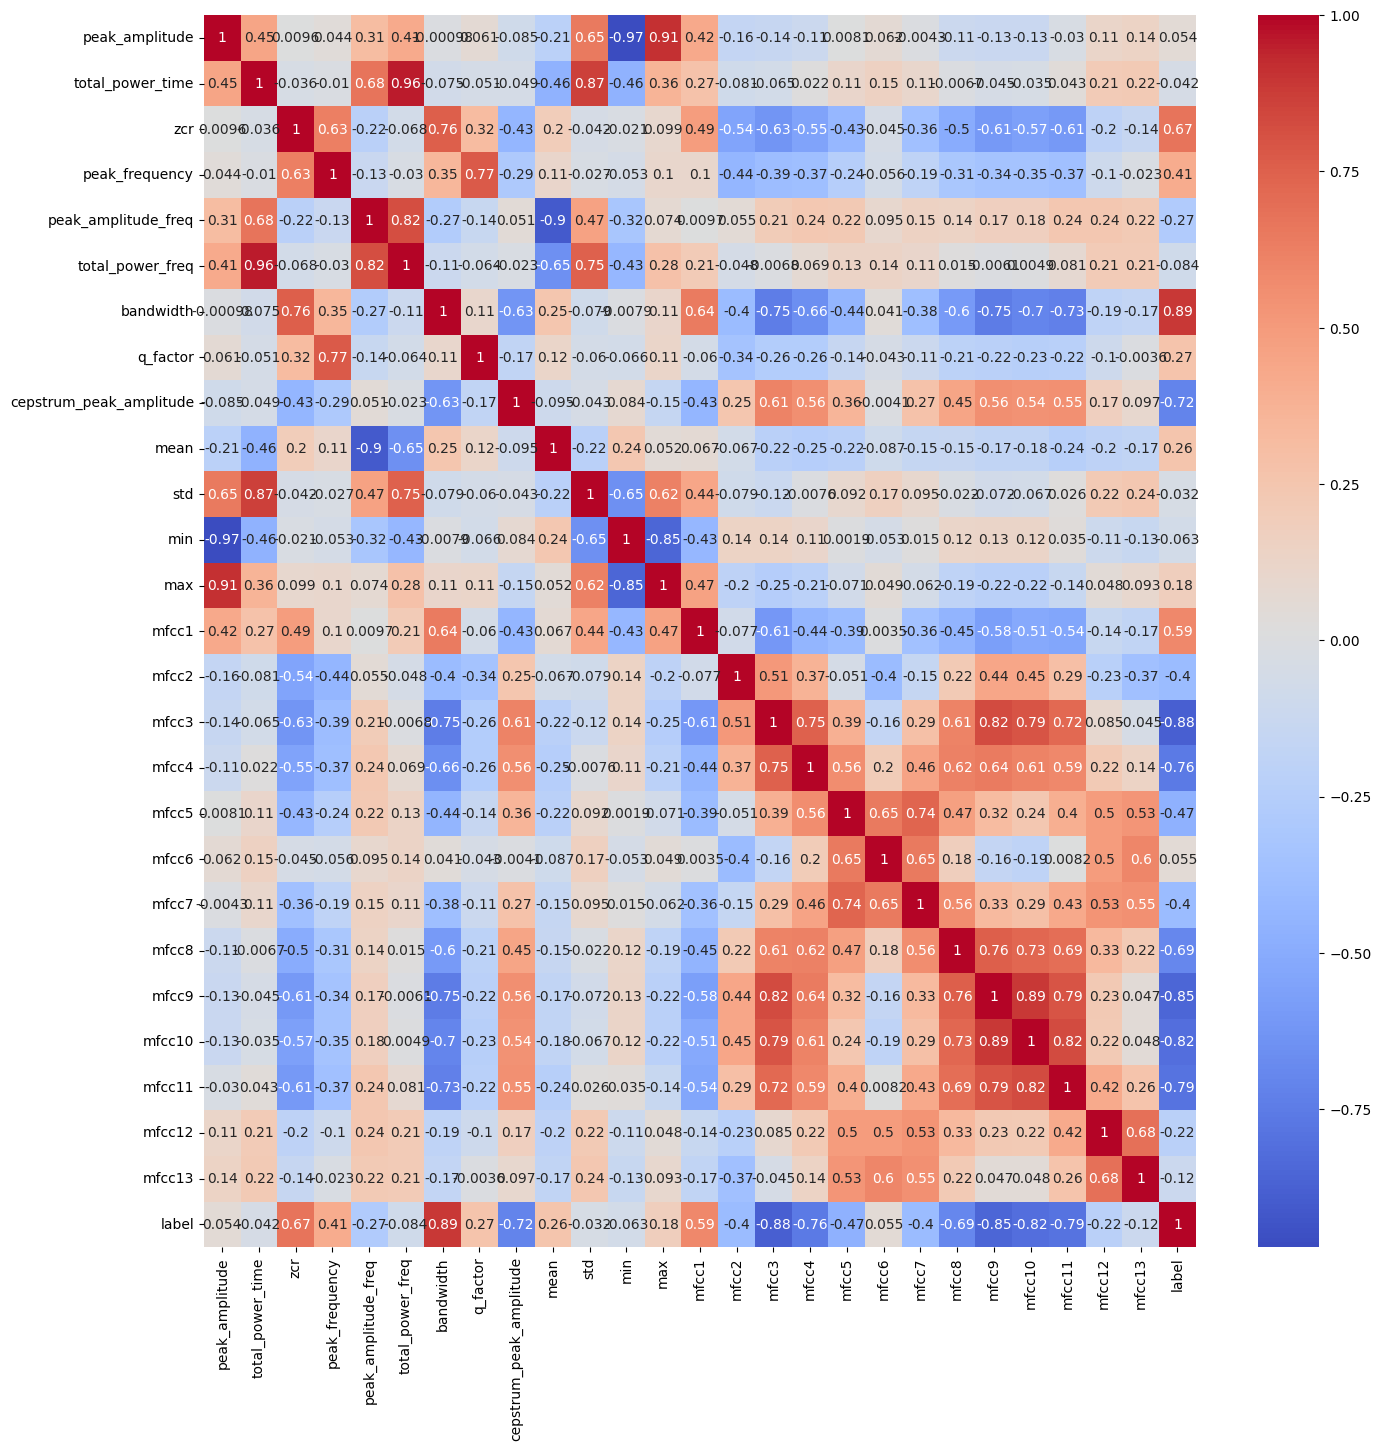

In [27]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

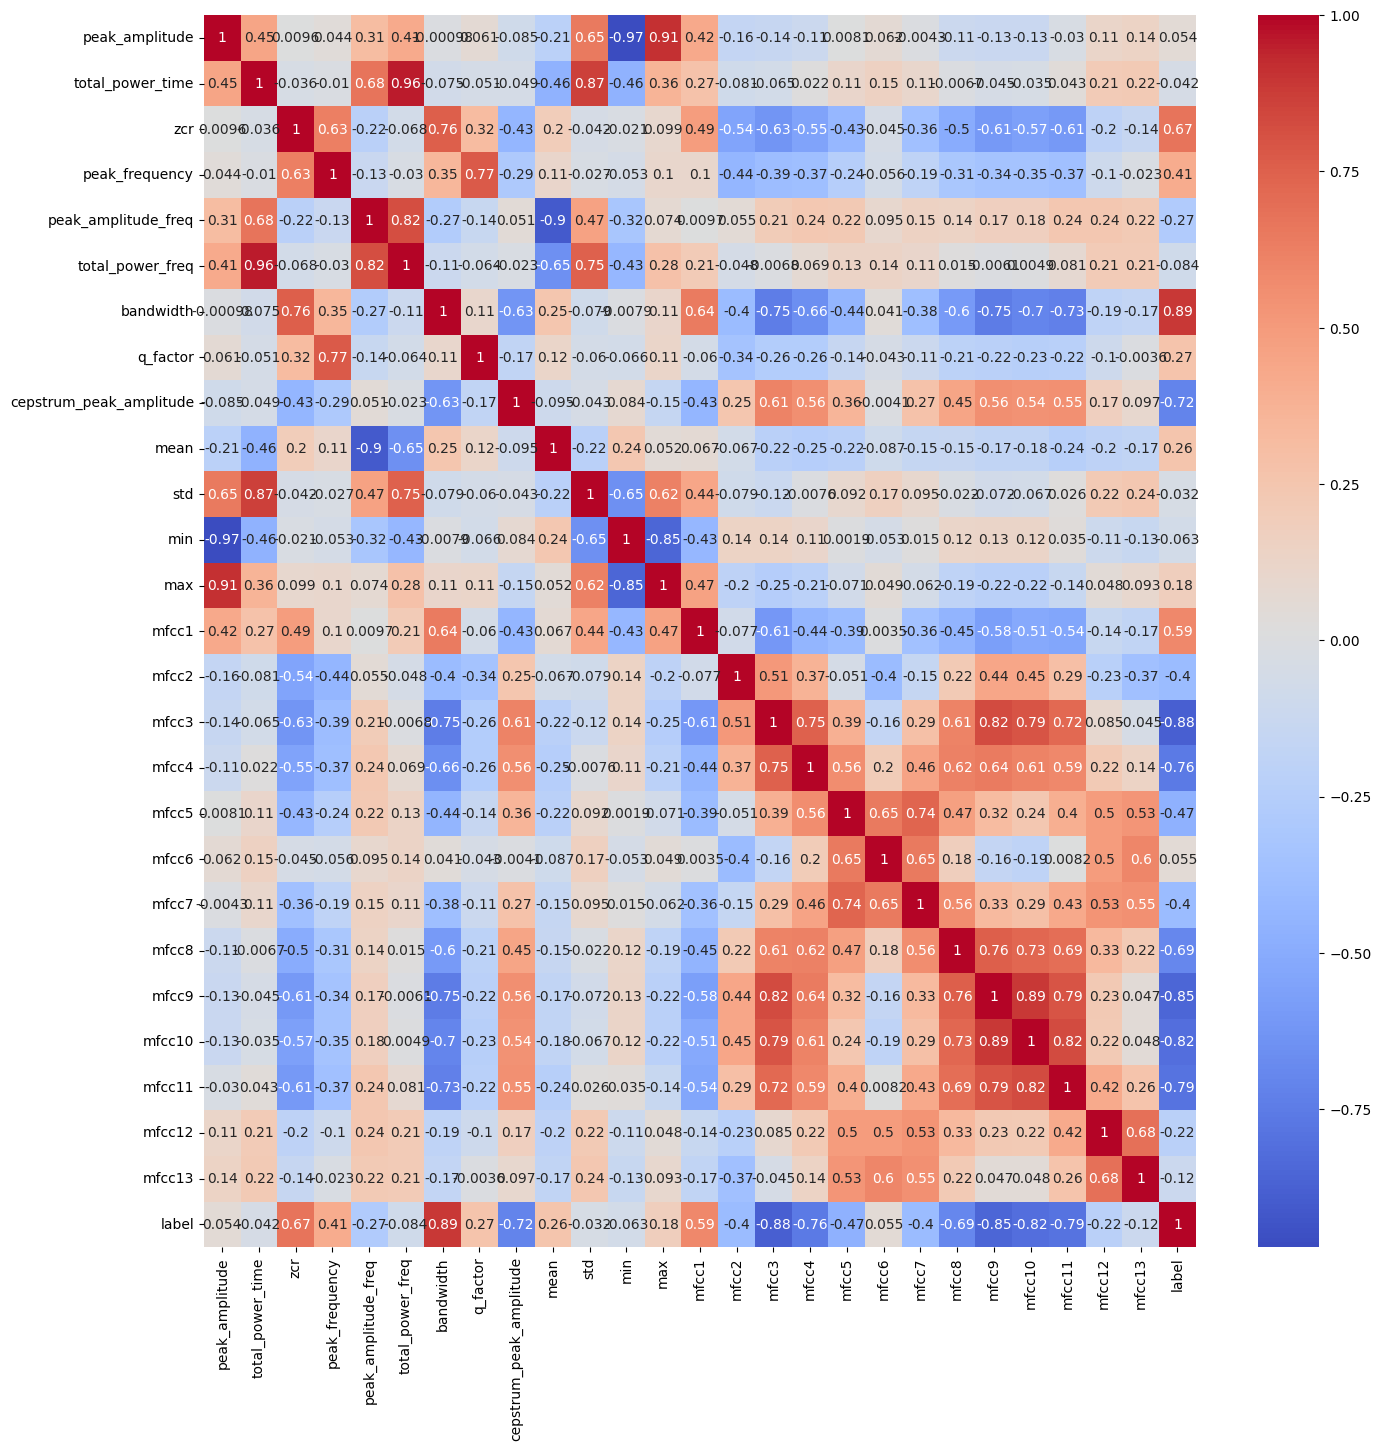

In [28]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_nr.corr(), annot=True, cmap='coolwarm')
plt.show()

In [29]:
# Downsample majority for balanced dataset
def downsample_balance(df, label_col="label"):
    counts = df[label_col].value_counts()
    min_count = counts.min()
    balanced_df_list = []

    for label in counts.index:
        df_label = df[df[label_col] == label]
        if len(df_label) > min_count:
            df_label_downsampled = df_label.sample(n=min_count, random_state=42)
        else:
            df_label_downsampled = df_label
        balanced_df_list.append(df_label_downsampled)

    balanced_df = pd.concat(balanced_df_list).sample(frac=1, random_state=42)
    print("Downsampled dataset:", balanced_df[label_col].value_counts().to_dict())
    return balanced_df

In [30]:
# Benchmark Function
def run_benchmark(df, label_col="label", drop_corr=True, balance_data=False, save_models=True, save_dir="saved_models", validation_df=None):
    data = df.copy()

    # Drop correlated features
    if drop_corr:
        corr_matrix = data.drop(label_col, axis=1).corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > 0.7)]
        print("Dropping correlated columns:", to_drop)
        data = data.drop(columns=to_drop)

    # Upsample minority class if balance_data=True
    if balance_data:
        majority = data[data[label_col] == data[label_col].mode()[0]]
        minority = data[data[label_col] != data[label_col].mode()[0]]
        minority_upsampled = resample(minority,
                                      replace=True,
                                      n_samples=len(majority),
                                      random_state=42)
        data = pd.concat([majority, minority_upsampled])
        data = data.sample(frac=1, random_state=42)
        print("Balanced (upsampled) dataset:", data[label_col].value_counts().to_dict())

    # Split features and target
    X = data.drop(label_col, axis=1)
    y = data[label_col]
    feature_names = X.columns

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scalers to test
    scalers = {
        "StandardScaler": StandardScaler(),
        "MinMaxScaler": MinMaxScaler(),
        "RobustScaler": RobustScaler()
    }

    # ML Models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "SVM": SVC(random_state=42, probability=True),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42)
    }

    results = []

    # Train ML models
    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            results.append({
                "Model": model_name,
                "Scaler": scaler_name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "F1": f1_score(y_test, y_pred, average="weighted", zero_division=0)
            })

            # Save the model and scaler
            if save_models:
                model_path = os.path.join(save_dir, model_name.replace(" ", "_"), scaler_name)
                os.makedirs(model_path, exist_ok=True)
                with open(os.path.join(model_path, "model.pkl"), "wb") as f:
                    pickle.dump(model, f)
                with open(os.path.join(model_path, "scaler.pkl"), "wb") as f:
                    pickle.dump(scaler, f)

    # Train DL model with different scalers
    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        dl_model = Sequential([
            Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
            Dropout(0.3),
            Dense(64, activation="relu"),
            Dropout(0.3),
            Dense(1, activation="sigmoid")
        ])

        dl_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

            # Early stopping callback
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

        dl_model.fit(
            X_train_scaled,
            y_train,
            epochs=50,               # Increase epochs; training will stop early if no improvement
            batch_size=32,
            verbose=0,
            validation_split=0.1,
            callbacks=[early_stop]
        )

        y_pred_dl = (dl_model.predict(X_test_scaled) > 0.5).astype(int)

        results.append({
            "Model": "Deep Learning (NN)",
            "Scaler": scaler_name,
            "Accuracy": accuracy_score(y_test, y_pred_dl),
            "Precision": precision_score(y_test, y_pred_dl, average="weighted", zero_division=0),
            "Recall": recall_score(y_test, y_pred_dl, average="weighted", zero_division=0),
            "F1": f1_score(y_test, y_pred_dl, average="weighted", zero_division=0)
        })

        # Save DL model and scaler
        if save_models:
            model_path = os.path.join(save_dir, "Deep_Learning_NN", scaler_name)
            os.makedirs(model_path, exist_ok=True)
            dl_model.save(os.path.join(model_path, "model.h5"))
            with open(os.path.join(model_path, "scaler.pkl"), "wb") as f:
                pickle.dump(scaler, f)

    results_df = pd.DataFrame(results)
    return results_df

In [31]:
df_downsampled = downsample_balance(df, label_col="label")
results_balanced_down = run_benchmark(df_downsampled, drop_corr=False, balance_data=False, save_dir="other_saved_models/balanced_down")
results_balanced_down["Scenario"] = "Balanced Down"

results_balanced_down = run_benchmark(df_downsampled, drop_corr=True, balance_data=False, save_dir="other_saved_models/balanced_down_corr")
results_balanced_down["Scenario"] = "Balanced Down With Corr Removed"

# noise treated
df_downsampled_nr = downsample_balance(df_nr, label_col="label")
results_balanced_down_nr = run_benchmark(df_downsampled_nr, drop_corr=False, balance_data=False, save_dir="nr_other_saved_models/balanced_down")
results_balanced_down_nr["Scenario"] = "Balanced Down"

results_balanced_down_nr = run_benchmark(df_downsampled_nr, drop_corr=True, balance_data=False, save_dir="nr_other_saved_models/balanced_down_corr")
results_balanced_down_nr["Scenario"] = "Balanced Down With Corr Removed"

Downsampled dataset: {0: 2000, 1: 2000}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Dropping correlated columns: ['total_power_freq', 'bandwidth', 'q_factor', 'mean', 'std', 'min', 'max', 'mfcc3', 'mfcc4', 'mfcc9', 'mfcc10', 'mfcc11']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Downsampled dataset: {0: 2000, 1: 2000}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Dropping correlated columns: ['total_power_freq', 'bandwidth', 'q_factor', 'mean', 'std', 'min', 'max', 'mfcc3', 'mfcc4', 'mfcc9', 'mfcc10', 'mfcc11']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [32]:
data = df.copy()
corr_matrix = data.drop("label", axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.7)]
to_drop

['total_power_freq',
 'bandwidth',
 'q_factor',
 'mean',
 'std',
 'min',
 'max',
 'mfcc3',
 'mfcc4',
 'mfcc7',
 'mfcc9',
 'mfcc10',
 'mfcc11']

In [33]:
df_corr_columns = pd.DataFrame({'name': to_drop})
df_corr_columns.to_csv(f'{project_dir}/data/corr_columns_other_dataset.csv', index=False)

In [34]:
data = df_nr.copy()
corr_matrix = data.drop("label", axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.7)]
to_drop

['total_power_freq',
 'bandwidth',
 'q_factor',
 'mean',
 'std',
 'min',
 'max',
 'mfcc3',
 'mfcc4',
 'mfcc7',
 'mfcc9',
 'mfcc10',
 'mfcc11']

In [35]:
df_corr_columns = pd.DataFrame({'name': to_drop})
df_corr_columns.to_csv(f'{project_dir}/data/nr_corr_columns_other_dataset.csv', index=False)

In [36]:
results = pd.concat([results_balanced_down, results_balanced_down_nr])
results_nr = pd.concat([results_balanced_down_nr, results_balanced_down])

In [37]:
print("\nFinal Combined Results:\n", results)

print("\nFinal Combined Results:\n", results_nr)


Final Combined Results:
                   Model          Scaler  Accuracy  Precision   Recall  \
0   Logistic Regression  StandardScaler   0.99750   0.997500  0.99750   
1                   SVM  StandardScaler   0.99750   0.997500  0.99750   
2                   KNN  StandardScaler   0.99500   0.995012  0.99500   
3         Decision Tree  StandardScaler   0.99500   0.995012  0.99500   
4         Random Forest  StandardScaler   0.99750   0.997512  0.99750   
5     Gradient Boosting  StandardScaler   0.99875   0.998753  0.99875   
6              AdaBoost  StandardScaler   0.99625   0.996278  0.99625   
7   Logistic Regression    MinMaxScaler   0.99125   0.991278  0.99125   
8                   SVM    MinMaxScaler   0.99750   0.997500  0.99750   
9                   KNN    MinMaxScaler   0.99625   0.996253  0.99625   
10        Decision Tree    MinMaxScaler   0.99500   0.995012  0.99500   
11        Random Forest    MinMaxScaler   0.99750   0.997512  0.99750   
12    Gradient Boosting  

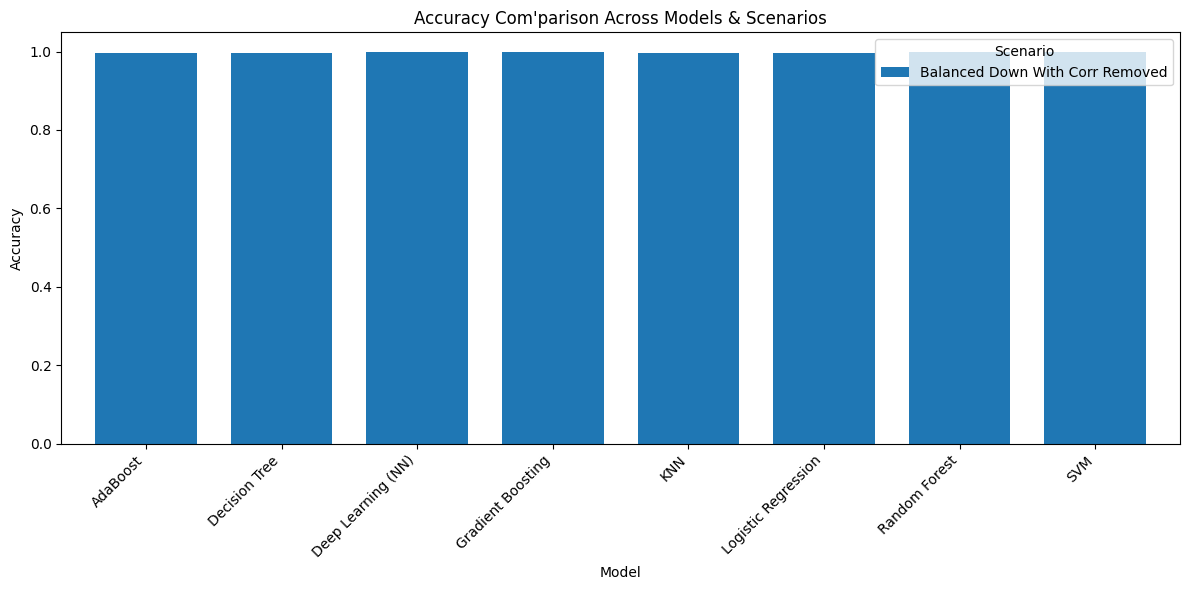

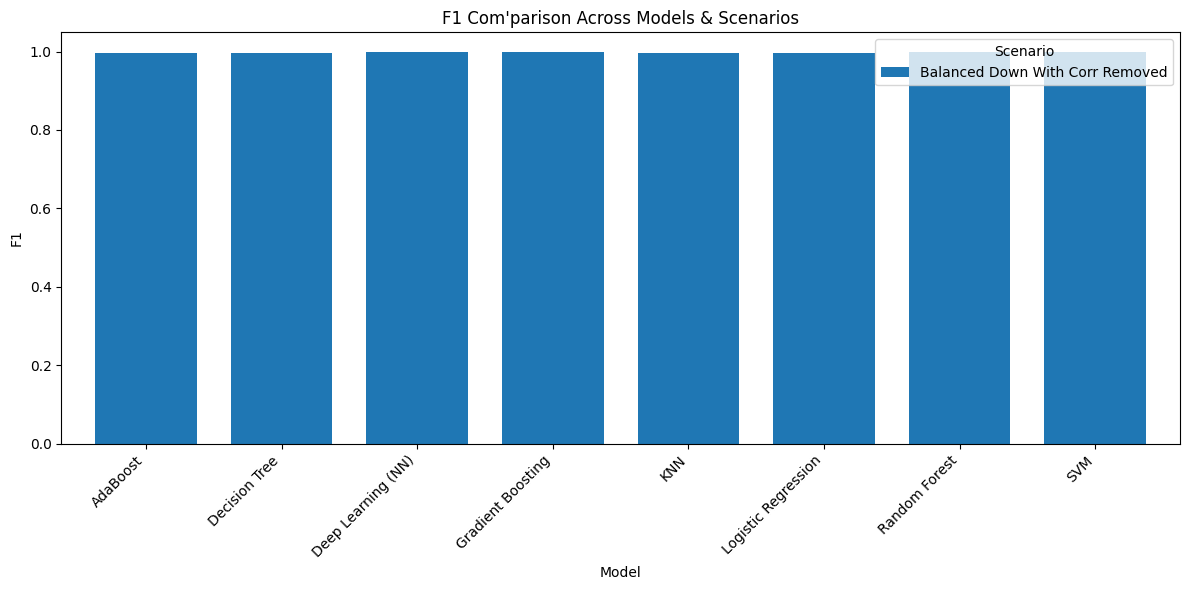

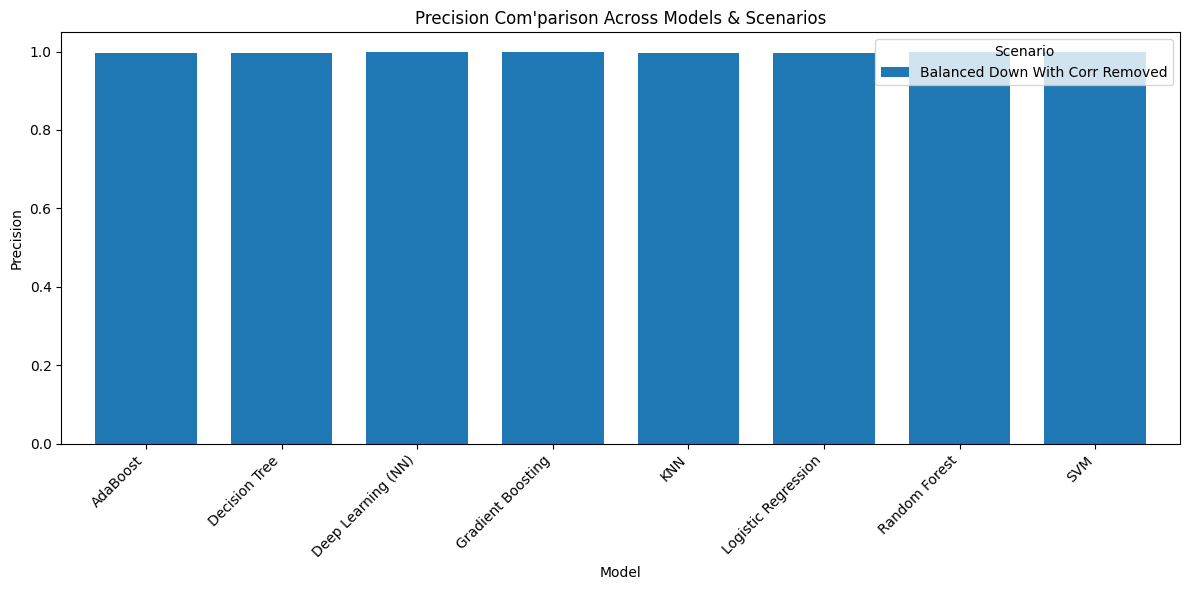

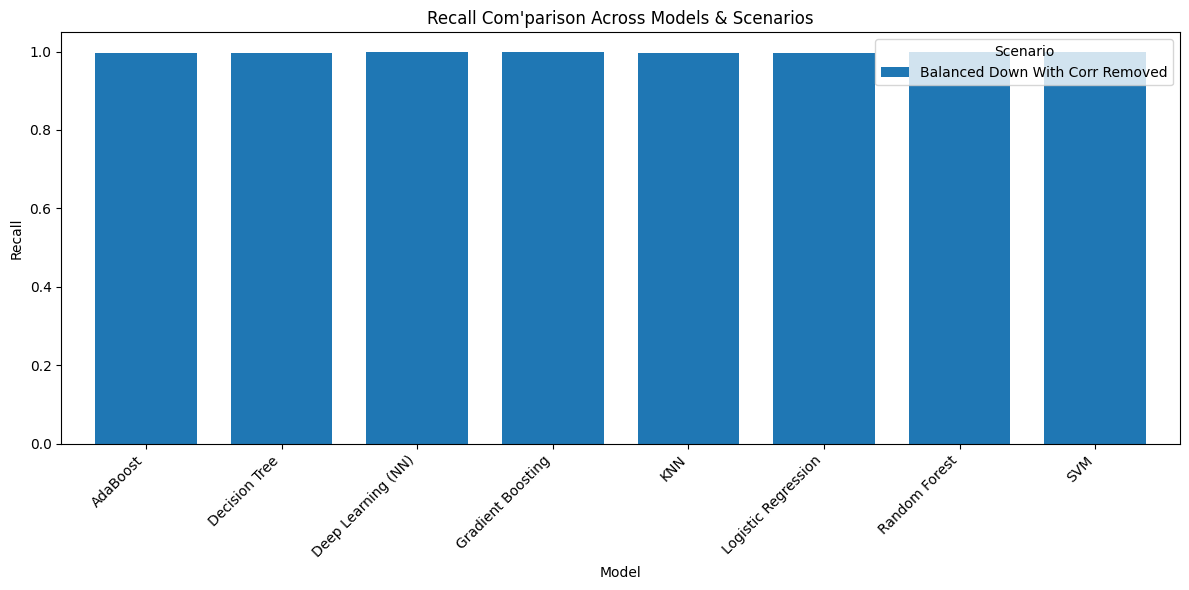

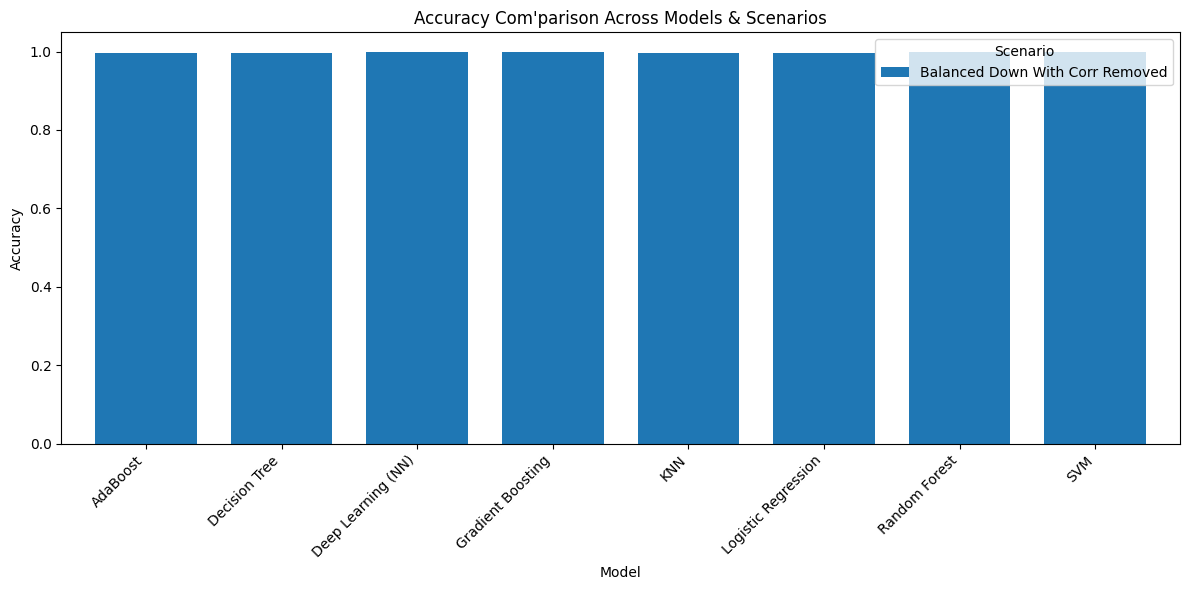

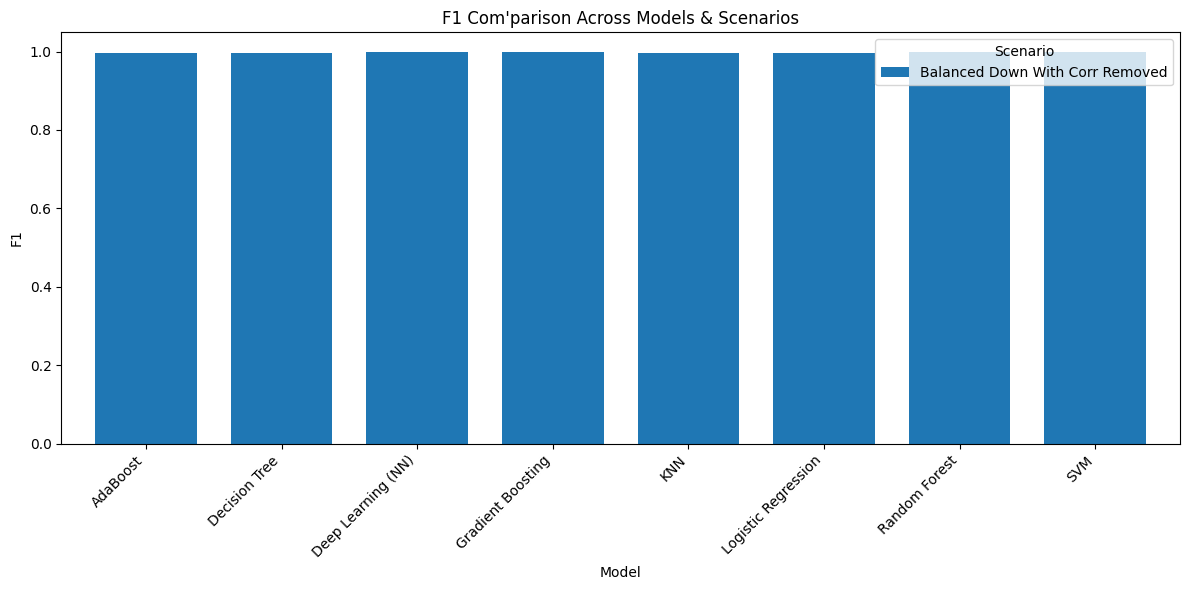

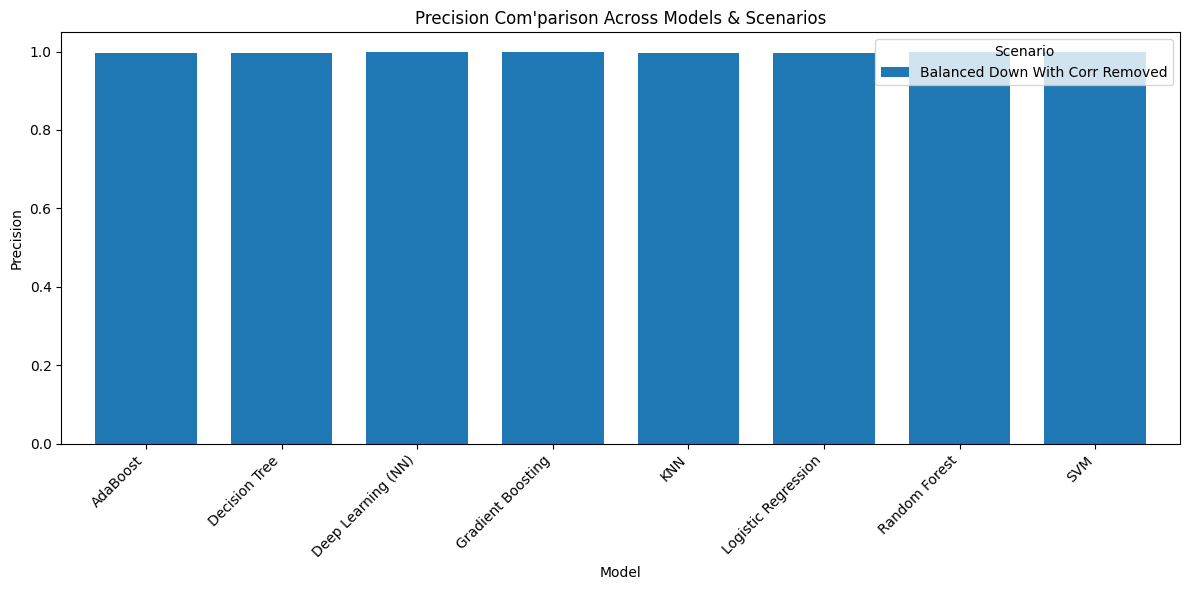

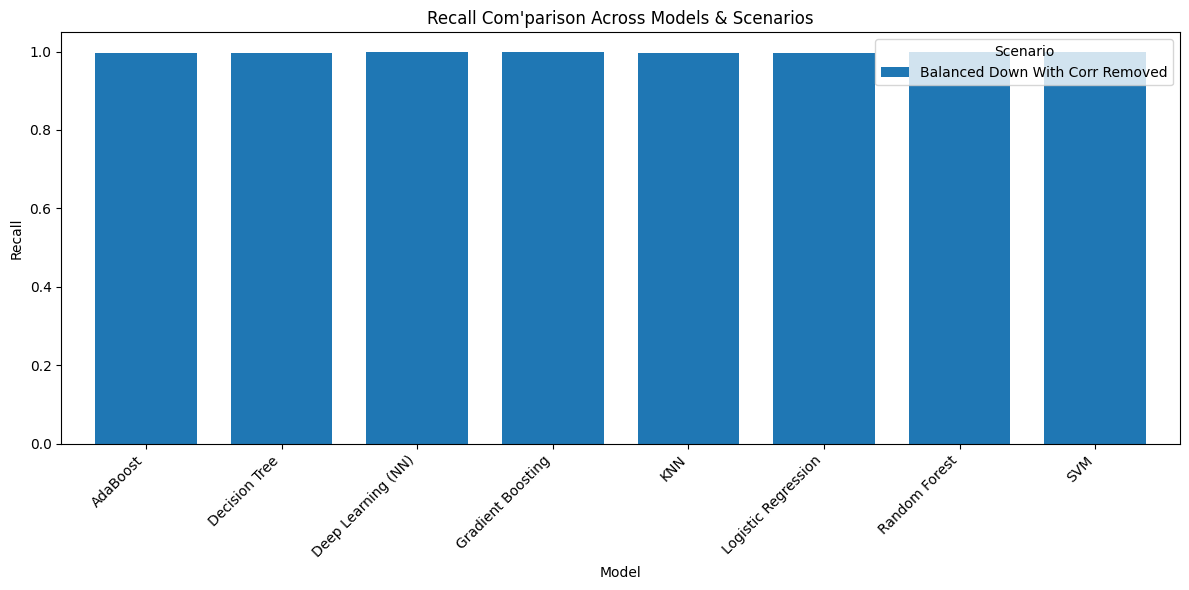

In [38]:
# Plot results
def plot_results(results_df):
    metrics = ["Accuracy", "F1", "Precision", "Recall"]

    for metric in metrics:
        plt.figure(figsize=(12, 6))
        pivot_df = results_df.pivot_table(
            index="Model",
            columns="Scenario",
            values=metric,
            aggfunc="mean"
        )
        pivot_df.plot(kind="bar", width=0.75, ax=plt.gca())
        plt.title(f"{metric} Com'parison Across Models & Scenarios")
        plt.ylabel(metric)
        plt.xlabel("Model")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Scenario")
        plt.tight_layout()
        plt.show()

# Call plotting
plot_results(results)
plot_results(results_nr)

In [43]:
# Select the best model based on F1 score
best_model_row = results.loc[results["F1"].idxmax()]

print("Best Model Overall:")
print(f"Model: {best_model_row['Model'].iloc[0]}")
print(f"Scaler: {best_model_row['Scaler'].iloc[0]}")
print(f"Scenario: {best_model_row['Scenario'].iloc[0]}")
print(f"Accuracy: {best_model_row['Accuracy'].iloc[0]:.4f}")
print(f"Precision: {best_model_row['Precision'].iloc[0]:.4f}")
print(f"Recall: {best_model_row['Recall'].iloc[0]:.4f}")
print(f"F1 Score: {best_model_row['F1'].iloc[0]:.4f}")

Best Model Overall:
Model: Deep Learning (NN)
Scaler: RobustScaler
Scenario: Balanced Down With Corr Removed
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [44]:
# Select the best model based on F1 score
best_model_row = results_nr.loc[results_nr["F1"].idxmax()]

print("Best Model Overall:")
print(f"Model: {best_model_row['Model'].iloc[0]}")
print(f"Scaler: {best_model_row['Scaler'].iloc[0]}")
print(f"Scenario: {best_model_row['Scenario'].iloc[0]}")
print(f"Accuracy: {best_model_row['Accuracy'].iloc[0]:.4f}")
print(f"Precision: {best_model_row['Precision'].iloc[0]:.4f}")
print(f"Recall: {best_model_row['Recall'].iloc[0]:.4f}")
print(f"F1 Score: {best_model_row['F1'].iloc[0]:.4f}")

Best Model Overall:
Model: Deep Learning (NN)
Scaler: RobustScaler
Scenario: Balanced Down With Corr Removed
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [45]:
results.to_csv(f'{project_dir}/other_sounds_results_uncleaned_dataset.csv', index=False)
results_nr.to_csv(f'{project_dir}/other_sounds_results_for_noise_treated_dataset.csv', index=False)